<a href="https://colab.research.google.com/github/giuliocapecchi/LM-project/blob/main/lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
# %pip install torch huggingface_hub python-dotenv transformers sentence-transformers pymupdf langchain langchain-community langchain-huggingface chromadb tqdm unidecode gradio bitsandbytes seaborn

In [87]:
import os
import torch
from huggingface_hub import login
from dotenv import load_dotenv
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
from sentence_transformers import SentenceTransformer
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
import time
from tqdm import tqdm
import re
import gradio as gr
from unidecode import unidecode
import random
import gdown

In [90]:
PDF_NAME = "IR Slides v1.0.pdf"
running_on_colab = False

try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("Running in Google Colab. Using userdata to get HF_TOKEN.")
    # save locally from https://drive.google.com/file/d/1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY/view?usp=drive_link
    gdown.download(id="1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY", output=PDF_NAME, quiet=False)
    running_on_colab = True
except ModuleNotFoundError:
    load_dotenv()
    HF_TOKEN = os.getenv('HF_TOKEN')
    print("Not running in Google Colab. Using load_dotenv to get HF_TOKEN.")

file_path = PDF_NAME
login(token=HF_TOKEN)

Running in Google Colab. Using userdata to get HF_TOKEN.


Downloading...
From: https://drive.google.com/uc?id=1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY
To: /content/IR Slides v1.0.pdf
100%|██████████| 85.5M/85.5M [00:00<00:00, 240MB/s]


In [91]:
def preprocess_text(text):
    # Rimuovi formule matematiche LaTeX
    text = re.sub(r'\$.*?\$', '', text)
    # Rimuovi caratteri non alfanumerici eccetto punteggiatura di base
    text = re.sub(r'[^a-zA-Z0-9\s.,;:!?\'"-]', '', text)
    # Rimuovi •
    text = text.replace('•', '')
    # Normalizza i caratteri Unicode
    text = unidecode(text)
    # Rimuovi spazi multipli
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def aggregate_short_documents(texts, min_length=50):
    aggregated_texts = []
    buffer = ""

    for doc in texts:
        if len(doc.page_content) < min_length:
            buffer += " " + doc.page_content
            buffer = buffer.strip()
        else:
            if buffer:
                doc.page_content = buffer + " " + doc.page_content
                buffer = ""
            aggregated_texts.append(doc)

    if buffer:
        if aggregated_texts:
            aggregated_texts[-1].page_content += " " + buffer
        else:
            aggregated_texts.append(buffer)

    return aggregated_texts

# ------------------------------------------------------------------------- #

# Load and process the PDF
loader = PyMuPDFLoader(file_path=file_path)
documents = loader.load()

# Split the documents into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200, separator="\n")
texts = text_splitter.split_documents(documents)

# Preprocess the text
for doc in texts:
    doc.page_content = preprocess_text(doc.page_content)

# Aggrega i documenti corti
corpus = aggregate_short_documents(texts)

In [92]:
# print some random pages with their indices
random.seed(42)
for i in range(5):
    doc = random.choice(corpus)
    doc_index = corpus.index(doc)
    print(f"DocId: {doc_index}, {doc.page_content[:100]}...")

DocId: 57, Ranked Retrieval In Boolean retrieval documents either match or dont a query Good for expert users w...
DocId: 12, cat command: reads files sequentially, writing them to the standard output tr command: copies the st...
DocId: 140, Given the sample space , the function is called probability. For each event , we denote as the proba...
DocId: 125, Example Assume relevant documents in total Assume an impatient user, i.e., RB 8 b 2 DCG10 3 1 log2 3...
DocId: 114, Rank-based Metrics Precision at document cutoff : where is the relevance judgment of the -th retriev...


In [93]:
print(f"Average document length: {sum(len(doc.page_content) for doc in corpus) / len(corpus)}")

Average document length: 464.3265993265993


In [94]:
import os

def save_documents(documents):
    if not os.path.exists("vector_store"):
        os.makedirs("vector_store")
    # delete all files in the vector_store directory
    for file in os.listdir("vector_store"):
        os.remove(os.path.join("vector_store", file))
    for i, doc in enumerate(documents):
        with open(f"vector_store/document_{i}.txt", "w", encoding="utf-8") as f:
            f.write(doc.page_content)

save_documents(corpus)

In [95]:
print(f"Saved {len(corpus)} documents in the vector_store directory.")

Saved 297 documents in the vector_store directory.


In [96]:
import json

def extract_questions(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    questions = []
    for item in data:
        # q = item.get("question", "")
        # a = item.get("answers", "")
        # # 'a' è una lista di stringhe, aggiungi ad ognuno 1, 2, 3, 4
        # for i in range(len(a)):
        #     a[i] = f"{(1 + i)}) {a[i]}"
        # a = " ".join(a)
        # qplusa = f"{q} {a}"
        if str(item.get("category", "")) == "1":
            continue
        question = {
            "question": item.get("question", "").strip(),
            # "answers": item.get("answers", ""),
            # "correct": item.get("correct", ""),
            # "category": item.get("category", ""),
            # "question_id": item.get("question_id", "")
        }
        questions.append(question)
    return questions


file_path = "quiz/quiz.json"

if running_on_colab:
  if not os.path.exists("quiz"):
      os.makedirs("quiz")
  # save locally from https://drive.google.com/file/d/15pKNg7XwtaUILmxUhzhNa-ojTpqqLg__/view?usp=drive_link
  gdown.download(id="15pKNg7XwtaUILmxUhzhNa-ojTpqqLg__", output=file_path, quiet=False)

queries = extract_questions(file_path)
print(f"Loaded {len(queries)} questions.")

random.seed(4242)
print(random.choice(queries))

Downloading...
From: https://drive.google.com/uc?id=15pKNg7XwtaUILmxUhzhNa-ojTpqqLg__
To: /content/quiz/quiz.json
100%|██████████| 29.9k/29.9k [00:00<00:00, 30.0MB/s]

Loaded 60 questions.
{'question': 'Which of the following metrics is used to measure overlap between two sets?'}


# 1. Gather dataset embeddings
- CDE works by first getting a set of embeddings from corpus documents that is intended to be representative of the overall corpus. We first sample a number of documents from the corpus (this model is trained with 512 documents from each context) and get their embeddings from our first-stage model.
- Now that we have obtained "dataset embeddings" we can embed documents and queries like normal. Remember to use the document prompt for documents:

model card : https://huggingface.co/jxm/cde-small-v1

In [97]:
from sentence_transformers import SentenceTransformer

# with sentence-transformers we don't need prefixes but, to do retrieval, we need to use prompt_name="query" and prompt_name="document" in the encode method of the model when embedding queries and documents, respectively.
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load the embeddings model
embeddings_model = SentenceTransformer("jxm/cde-small-v1", trust_remote_code=True).to(device)

Using device: cuda


/root/.cache/huggingface/modules/transformers_modules/nomic-ai/nomic-bert-2048/eb02ceb48c1fdcc477ff1925c9732c379f0f0d1f/modeling_hf_nomic_bert.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

Disabled 37 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.BiEncoder'>
modified 12 rotary modules – set rotary_start_pos to 512
Disabled 74 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.DatasetTransformer'>


In [98]:
minicorpus_size = embeddings_model[0].config.transductive_corpus_size # 512
minicorpus_docs = random.choices(corpus, k=minicorpus_size) # oversampling is okay
assert len(minicorpus_docs) == minicorpus_size # You must use exactly this many documents in the minicorpus. You can oversample if your corpus is smaller.

dataset_embeddings = embeddings_model.encode(
    [doc.page_content for doc in minicorpus_docs],
    prompt_name="document",
    convert_to_tensor=True,
    show_progress_bar=True
)

print(f"Corpus size: {len(corpus)}")
print(f"Computed embeddings for {len(minicorpus_docs)} documents. Shape: {dataset_embeddings.shape}")

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Corpus size: 297
Computed embeddings for 512 documents. Shape: torch.Size([512, 768])


In [99]:
print("Some mini-corpus documents:")

# get some random documents from the minicorpus
random.seed(4242)
for i in random.sample(range(minicorpus_size), 5):
    print(f"document {i}: {minicorpus_docs[i].page_content[:100]}...")

Some mini-corpus documents:
document 425: Term Distribution Also known as distributed global indexing Single index is built for the whole clus...
document 134: Link Analysis Link-based ranking: use hyperlinks to rank web documents Use link counts as simple mea...
document 29: Cascading Query Index Processing 1,000 10,000 docs Base Ranker Inverted Index First Stage Top Ranker...
document 399: Multimedia Information Retrieval and Computer Vision nicola.tonellottounipi.it...
document 388: description lang"so"Hel wargelinada sunta cayayaanka ee cuntada ilmaha.description description lang"...


# 2. Get doc embeddings

In [100]:
doc_embeddings = embeddings_model.encode(
    [doc.page_content for doc in corpus],
    prompt_name="document",
    dataset_embeddings=dataset_embeddings, # this is the contexualized embeddings of the minicorpus
    convert_to_tensor=True,
    show_progress_bar=True
)

query_embeddings = embeddings_model.encode(
    [query['question'] for query in queries],
    prompt_name="query",
    dataset_embeddings=dataset_embeddings,  # this is the contexualized embeddings of the minicorpus
    convert_to_tensor=True,
    show_progress_bar=True
)

print(f"Document embeddings shape: {doc_embeddings.shape}")
print(f"Query embeddings shape: {query_embeddings.shape}")

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Document embeddings shape: torch.Size([297, 768])
Query embeddings shape: torch.Size([60, 768])


In [101]:
similarities = embeddings_model.similarity(query_embeddings, doc_embeddings)
print("'similarities' shape : ",similarities.shape)
topk_values, topk_indices = similarities.topk(5)

random.seed(4242)
random_queries = random.sample(queries, 2)
for query in random_queries:
    query_idx = queries.index(query)
    print(f"Query: {query['question']}")
    for j, idx in enumerate(topk_indices[query_idx]):
        doc = corpus[idx]
        print(f"Rank {j+1} (Score: {topk_values[query_idx][j]:.4f}, Doc ID: {idx}): {doc.page_content[:200]}...")
    print()


'similarities' shape :  torch.Size([60, 297])
Query: Which of the following metrics is used to measure overlap between two sets?
Rank 1 (Score: 0.6110, Doc ID: 73): Jaccard Coefficient A common measure of overlap of two finite sets and : Always assigns a number between 0 and 1 and do not have to be the same size Note that and if What is the query-document match s...
Rank 2 (Score: 0.5788, Doc ID: 135): The -test assumes that the evaluation data is measure on an interval scale Differences between values are significant Effectiveness measures are an ordinal scale Differences between values are not sig...
Rank 3 (Score: 0.5662, Doc ID: 288): AB Testing Concept is fairly trivial: randomly split traffic between two or more versions A Control B Treatment Collect metrics of interest analyse Run statistical tests to confirm differences are not...
Rank 4 (Score: 0.5491, Doc ID: 113): Precision and recall are two different numbers to evaluate the effectiveness of an IR system Can we coalesce the

# 3. Chroma

In [102]:
from chromadb import Client, Collection

# Initialize the Chroma client
client = Client()

COLLECTION_NAME = "chroma-collection"

# Check if the collection exists and delete it if it does
if COLLECTION_NAME in [col.name for col in client.list_collections()]:
    client.delete_collection(name=COLLECTION_NAME)
    print(f"Collection {COLLECTION_NAME} exists, deleting it")
else:
    print(f"Collection {COLLECTION_NAME} does not exist")

Collection chroma-collection exists, deleting it


In [103]:
from chromadb import Documents, EmbeddingFunction, Embeddings

class CustomEmbeddingFunction(EmbeddingFunction):
    def __init__(self, mode="document"):
        self.mode = mode  # "document" or "query"

    def __call__(self, input: Documents) -> Embeddings:

        # se input è una lista di documenti, estrai il testo
        if isinstance(input, list):
            input = [doc if isinstance(doc, str) else doc.page_content for doc in input]

        # Genera embeddings usando il modello specifico
        embeddings = embeddings_model.encode(
            input,
            prompt_name=self.mode,
            dataset_embeddings=dataset_embeddings,
            convert_to_tensor=True,
            show_progress_bar=True
        ).cpu().numpy()

        return embeddings.tolist()

# Create an instance of your embedding function
doc_embedding_function = CustomEmbeddingFunction(mode="document")

# Create a Chroma collection with the custom embedding function
collection: Collection = client.create_collection(
    name=COLLECTION_NAME,
    embedding_function=doc_embedding_function,
    get_or_create=True,
    metadata={"hnsw:space": "cosine"} # l2 is the default but cosine is more suitable for this embedding function
)

# Add the documents to the collection
collection.add(
    ids=[str(i) for i in range(len(corpus))],  # Unique identifiers for the documents
    embeddings=doc_embeddings.cpu().numpy(),
    documents=[doc.page_content for doc in corpus],
)

In [104]:
#print(collection.peek()) # returns a list of the first 10 items in the collection
print(collection.count()) # returns the number of items in the collection

297


In [105]:
query_text = "How many bytes can UTF-8 use to encode a character?"
query_embedding_function = CustomEmbeddingFunction(mode="query")
query_embeddings = query_embedding_function(query_text)

results = collection.query(
    query_embeddings=query_embeddings,
    n_results=5
)
print(results)

# Print the results with the document IDs and scores
for i, (doc_id, score, doc) in enumerate(zip(results['ids'][0], results['distances'][0], results['documents'][0])):
    print(f"Rank {i+1}: Document ID: {doc_id}, Score: {1-score:.4f}, {doc[:200]}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'ids': [['4', '3', '1', '6', '5']], 'embeddings': None, 'documents': [["All Unicode characters larger than U007F are encoded as a sequence of two or more bytes, each of which has the most significant bit set This means that no ASCII byte can appear as part of any other character, because ASCII characters are the only characters whose leading bit is 0 The first byte of a multibyte sequence that represents a non-ASCII character is always in the range 0xC0 to 0xFD and it indicates how many bytes follow for this character One of 110xxxxx, 1110xxxx, 11110xxx, 111110xx, and 1111110x, where the x's may be 0's or 1's. The number of 1-bits following the first 1-bit up until the next 0-bit is the number of bytes in the rest of the sequence. All further bytes in a multibyte sequence start with the two bits 10 and are in the range 0x80 to 0xBF UTF-8 sequences must be of the following forms in binary, where the x's represent the bits from the code point, with the leftmost x-bit being its most sign

# 3. Compute scores between queries and documents

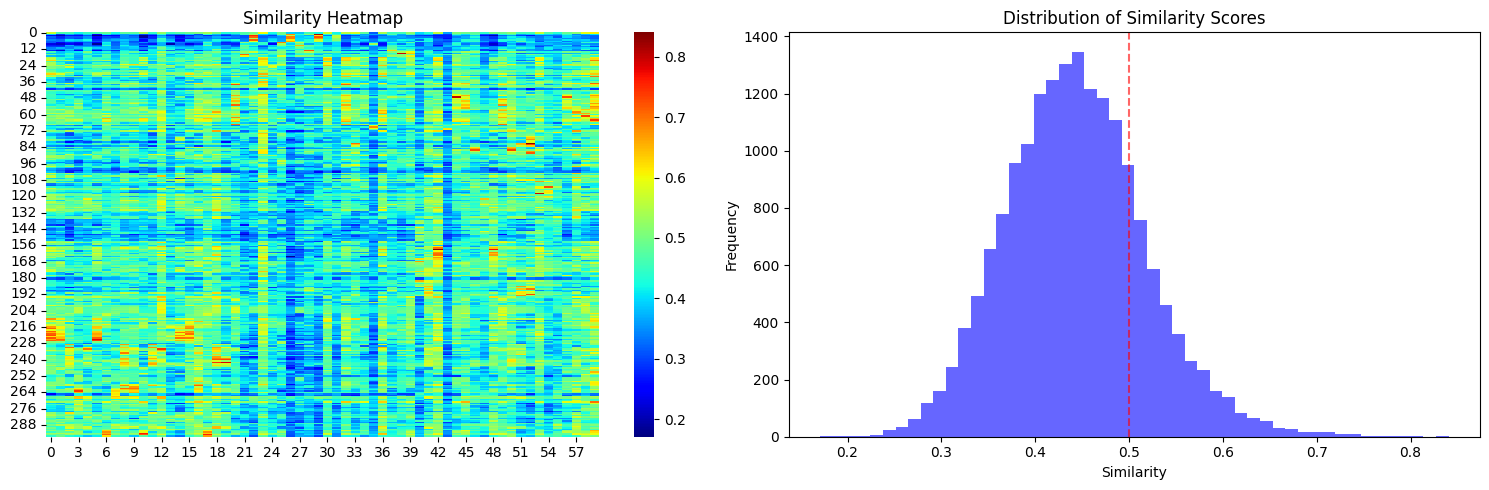

In [106]:
from seaborn import heatmap
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot heatmap
heatmap(similarities.cpu().numpy().T, cmap="jet", ax=axes[0])
axes[0].set_title("Similarity Heatmap")

# Plot histogram
axes[1].hist(similarities.cpu().flatten(), bins=50, color='blue', alpha=0.6)
axes[1].set_title("Distribution of Similarity Scores")
axes[1].set_xlabel("Similarity")
axes[1].set_ylabel("Frequency")
axes[1].axvline(x=0.5, color='red', alpha=0.6, linestyle='--')

plt.tight_layout()
plt.show()

# LLM

In [107]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # TODO : riguardare che fa

MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"

# Quantization is a technique that reduces the precision of
# the model’s weights to make it run faster and consume less memory,
# often at the cost of a slight reduction in model accuracy or quality
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                      # Lower precision reduces memory usage and can speed up inference (maybe try 8)
    bnb_4bit_use_double_quant=True,         # Using double quantization can help reduce the loss in accuracy associated with quantization
    bnb_4bit_quant_type="nf4",              # Normal Float 4-bit quantization, a scheme that may preserve model quality better than straightforward quantization methods
    bnb_4bit_compute_dtype=torch.bfloat16,  # The internal compute dtype used during inference. bfloat16 (BF16) is often chosen because it’s efficient on modern accelerators
    llm_int8_enable_fp32_cpu_offload=True   # Enable FP32 CPU offload
)

llm_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map={"": device},  # Custom device map to ensure all modules are on GPU
    quantization_config=bnb_config,
).to(device)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

generation_config = llm_model.generation_config
generation_config.max_new_tokens = 200                    # the maximum number of new tokens the model will generate (long outputs might be more prone to off-topic or repetitive content)
generation_config.min_new_tokens = 1                      # the minimum number of new tokens the model will generate
generation_config.temperature = 0.1                       # it controls the randomness of the generation, lower temp means more deterministic, conservative (less creative) and repetitive answers [about 0.1-1.2]
generation_config.top_p = 0.5                             # nucleus sampling controls how the model picks words based on their cumulative probability, lower value (0.5) means safer, more coherent text but less diverse [about 0.5-0.9]
generation_config.num_return_sequences = 1                # how many separate output sequences are returned for each generation prompt, get multiple different answers in one go, useful for picking the best response from several tries
generation_config.pad_token_id = tokenizer.eos_token_id   # special token IDs that represent padding and the end-of-sequence token. Generally, these are set to ensure the model knows when to stop and how to handle inputs of different lengths
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.repetition_penalty = 2.0                # discourages the model from repeating the same phrases or tokens over and over [about 1.0-2.0] (high value cause the model to avoid some tokens even if they are contextually appropriate)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [108]:
def retrieve_relevant_documents(query, k=5):
    query_embeddings = query_embedding_function(query)
    results = collection.query( # query the Chroma collection
        query_embeddings=query_embeddings,
        n_results=k
    )
    return results['documents'][0], results['distances'][0]

# test the function
query = "How many bytes can UTF-8 use to encode a character?"
print(f"Query: {query}")
documents, distances = retrieve_relevant_documents(query)
for doc, distance in (zip(documents, distances)):
    print(f"(score: {1-distance:.4f}) {doc[:200]}")

Query: How many bytes can UTF-8 use to encode a character?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(score: 0.6931) All Unicode characters larger than U007F are encoded as a sequence of two or more bytes, each of which has the most significant bit set This means that no ASCII byte can appear as part of any other ch
(score: 0.6924) Unicode is not a character encoding scheme Unicode code points are just numeric values assigned to characters Code points are not representations of characters as sequences of bytes For example, the c
(score: 0.6807) Text Processing Encodings The ASCII encoding maps characters to 7-bit integers using the range from 0 to 127 to represent 94 printing characters, 33 control characters, and the space since a byte is u
(score: 0.6640) Convert U05E7 to UTF-8 Determine that it is in the interval 0080 to 07FF, requiring two bytes: The encoding has the form: 110xxxxx 10xxxxxx Write the code point in binary: 0000 0101 1110 0111 The righ
(score: 0.6164) The table below shows the ranges of Unicode code points that map to the different UTF-8 sequence lengths Converting 

In [109]:
base_prompt = """You are an AI assistant for RAG. Your task is to understand the user question, and provide an answer using the provided contexts.

Your answers are correct, high-quality, and written by a domain expert. If the provided context does not contain the answer, simply state, "The provided context does not have the answer."

User question: {user_query}

Contexts:
{chunks_information}

Answer:
"""

In [110]:
# Example usage of the RAG system with the PDF
def answer_questions(questions):
    count = 0
    error = 0
    results = {}

    current_time = time.strftime("%m%d-%H%M%S")

    pbar = tqdm(questions, total=len(questions), desc="Answering questions...", unit="question")
    for q in pbar:
        top_k_chunks = retrieve_relevant_documents(q['question'], k=5)
        retrieved_chunks = [chunk for chunk in top_k_chunks]
        prompt = base_prompt.format(user_query=q['question'], chunks_information="\n".join(retrieved_chunks))
        encoding = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.inference_mode():
            outputs = llm_model.generate(
                input_ids=encoding.input_ids,
                attention_mask=encoding.attention_mask,
                generation_config=generation_config,
                num_beams=5,  # Use beam search for better results
                early_stopping=True,  # Stop early if all beams finish
            )

        # Exclude the prompt tokens from the generated output
        generated_tokens = outputs[0][len(encoding.input_ids[0]):]
        generated_unpreprocessed_sequence = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
        match = re.search(r'\b[1-4]\b', generated_unpreprocessed_sequence)
        answer = match.group(0) if match else ""  # first number found or empty string

        with open(f"quiz/runs_basemodel/quiz_answers_{current_time}.txt", "a", encoding="utf-8") as f:
            f.write(f"Question: {q['question']}\nAnswer: {answer}\nCorrect answer:{q['correct']}\nGenerated unpreprocessed sequence: {generated_unpreprocessed_sequence}\n--------------------------------------------------------------------\n\n")

        results[q['question_id']] = answer

        if len(answer) != 1 or answer not in "1234":
            error += 1
        else:  # the format is correct, now check if the answer is correct
            if str(q['correct']) == answer:
                count += 1
        pbar.set_postfix(Corrects=f"{count}/{len(questions)}", Errors=error)

    print("-------------------------\tFINISHED RUN. Error count: ", error, "-------------------------")
    return results, count / len(questions) * 100

In [111]:
def query_rag_model(user_query):
    documents, distances = retrieve_relevant_documents(user_query, k=5) # retrieve the top 5 most relevant documents
    print(f"Number of retrieved documents: {len(documents)}")
    # Print the results
    for doc, distance in zip(documents, distances):
        print(f"(score: {1-distance:.4f}) {doc[:200]}")
    prompt = base_prompt.format(user_query=user_query, chunks_information="\n".join(documents))
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = llm_model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config,
            num_beams=5,
            early_stopping=True,
        )
    generated_tokens = outputs[0][len(encoding.input_ids[0]):]
    generated_unpreprocessed_sequence = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    print(f"Generated sequence: {generated_unpreprocessed_sequence}")
    return generated_unpreprocessed_sequence

iface = gr.Interface(
    fn=query_rag_model,
    inputs="text",
    outputs="text",
    title="RAG Model Query Interface",
    description="Ask questions to the RAG model and get answers based on the provided PDF context."
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://57ed5d7e0c078791cc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
